<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/machine_learning/exp/Random_forest_Modular_Correct(Daily_New)111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install yfinance

In [48]:
# Import libraries
import os
import sys
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
#from pykalman import KalmanFilter
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [49]:
#@title Technical Analysis
# Import Built-Ins


# Import Homebrew

# Init Logging Facilities
log = logging.getLogger(__name__)

def find_window_high_low(df,lookback_days):

	"""
	Get the highs and lows in a lookback window.
	Parameters
	----------
	high : DataFrame
	High price for each ticker and date
	low : DataFrame
	Low price for each ticker and date
	lookback_days : int
	The number of days to look back
	Returns
	-------
	lookback_high : DataFrame
	Lookback high price for each ticker and date
	lookback_low : DataFrame
	Lookback low price for each ticker and date
	"""
	# compute rolling max from high prices and shift by one day to discard the current day
	lookback_high = df['High'].rolling(window=lookback_days, min_periods=lookback_days).max().shift()
	# compute rolling min from low prices and shift by one day to discard the current day
	lookback_low = df['Low'].rolling(window=lookback_days, min_periods=lookback_days).min().shift()
	t = pd.concat([lookback_high,lookback_low],axis=1)
	t.columns = ['Win_High',"Win_Low"]
	df=pd.concat([df,t], axis=1)
	# generate signals according to above condition
	long_short = df['Close'].copy()
	long_short[:] = 0
	long_short[df['Close'] > lookback_high] = 1
	long_short[df['Close'] < lookback_low] = -1
	long_short=pd.DataFrame(long_short)
	long_short.columns = ['Signals_from_Window_HiLo']
	df=pd.concat([df,long_short], axis=1)
	return df


def download_from_yahoo(ticker , start_date , end_date=False , Vol = False):
	
	'''Imports Data From Yahoo Finance
	 :param ticker : str(stock name)
	 :start_date : str(yyyy-dd-mm)
	 :end_date : str(yyyy-dd-mm) optional'''
	import fix_yahoo_finance as yf
	from pandas_datareader import data as pdr
	yf.pdr_override()
	if end_date==False:
		df = pdr.get_data_yahoo(ticker, start=start_date)
		df = df.dropna()
		df = df[['Open', "High" , "Low" , "Close" , "Volume"]]
	elif end_date!=False:
		df = pdr.get_data_yahoo(ticker, start=start_date , end=end_date)
		df = df.dropna()
		df = df[['Open', "High" , "Low" , "Close" , "Volume"]]
	'''	
	if end_date==end_date and Vol = False:
		df = pdr.get_data_yahoo(ticker, start=start_date,end = end_date)
		df = df.dropna()
		df = df.iloc[:,:4]	
	if end_date=end_date and Vol = True:
		df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
		df = df.dropna()
		df = df[['Open', "High" , "Low" , "Close" , "Volume"]]
	if end_date=False and Vol = True:	
		df = pdr.get_data_yahoo(ticker, start=start_date)
		df = df.dropna()
		df = df[['Open', "High" , "Low" , "Close" , "Volume"]]
	else :
		Print('Please Check All Inputs')
	'''	
	
	return df



def moving_average(df, n):
    """Calculate the moving average for the given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df


def exponential_moving_average(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    df = df.join(EMA)
    return df


def momentum(df, n):
    """
    
    :param df: pandas.DataFrame 
    :param n: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
    df = df.join(M)
    return df


def rate_of_change(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(n - 1)
    N = df['Close'].shift(n - 1)
    ROC = pd.Series(M / N, name='ROC_' + str(n))
    df = df.join(ROC)
    return df


def average_true_range(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    df.reset_index(inplace=True) 	
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean(), name='ATR_' + str(n))
    df = df.join(ATR)
    df = df.set_index('Date')
    return df


def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df


def ppsr(df):
    """Calculate Pivot Points, Supports and Resistances for given data
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    PP = pd.Series((df['High'] + df['Low'] + df['Close']) / 3)
    R1 = pd.Series(2 * PP - df['Low'])
    S1 = pd.Series(2 * PP - df['High'])
    R2 = pd.Series(PP + df['High'] - df['Low'])
    S2 = pd.Series(PP - df['High'] + df['Low'])
    R3 = pd.Series(df['High'] + 2 * (PP - df['Low']))
    S3 = pd.Series(df['Low'] - 2 * (df['High'] - PP))
    psr = {'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2, 'R3': R3, 'S3': S3}
    PSR = pd.DataFrame(psr)
    df = df.join(PSR)
    return df


def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    df = df.join(SOk)
    return df


def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    df = df.join(SOd)
    return df


def trix(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    df.reset_index(inplace=True)
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    df = df.join(Trix)
    df = df.set_index('Date')	
    return df


def average_directional_movement_index(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    df.reset_index(inplace=True)	
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    df = df.join(ADX)
    df=df.set_index('Date')	
    return df


def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df


def mass_index(df):
    """Calculate the Mass Index for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    Range = df['High'] - df['Low']
    EX1 = Range.ewm(span=9, min_periods=9).mean()
    EX2 = EX1.ewm(span=9, min_periods=9).mean()
    Mass = EX1 / EX2
    MassI = pd.Series(Mass.rolling(25).sum(), name='Mass Index')
    df = df.join(MassI)
    return df


def vortex_indicator(df, n):
    """Calculate the Vortex Indicator for given data.
    
    Vortex Indicator described here:
        http://www.vortexindicator.com/VFX_VORTEX.PDF
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    TR = [0]
    df.reset_index(inplace=True)
    while i < df.index[-1]:
        Range = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR.append(Range)
        i = i + 1
    i = 0
    VM = [0]
    while i < df.index[-1]:
        Range = abs(df.loc[i + 1, 'High'] - df.loc[i, 'Low']) - abs(df.loc[i + 1, 'Low'] - df.loc[i, 'High'])
        VM.append(Range)
        i = i + 1
    VI = pd.Series(pd.Series(VM).rolling(n).sum() / pd.Series(TR).rolling(n).sum(), name='Vortex_' + str(n))
    df = df.join(VI)
    df=df.set_index("Date") 	
    return df


def kst_oscillator(df, r1, r2, r3, r4, n1, n2, n3, n4):
    """Calculate KST Oscillator for given data.
    
    :param df: pandas.DataFrame
    :param r1: 
    :param r2: 
    :param r3: 
    :param r4: 
    :param n1: 
    :param n2: 
    :param n3: 
    :param n4: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(r1 - 1)
    N = df['Close'].shift(r1 - 1)
    ROC1 = M / N
    M = df['Close'].diff(r2 - 1)
    N = df['Close'].shift(r2 - 1)
    ROC2 = M / N
    M = df['Close'].diff(r3 - 1)
    N = df['Close'].shift(r3 - 1)
    ROC3 = M / N
    M = df['Close'].diff(r4 - 1)
    N = df['Close'].shift(r4 - 1)
    ROC4 = M / N
    KST = pd.Series(
        ROC1.rolling(n1).sum() + ROC2.rolling(n2).sum() * 2 + ROC3.rolling(n3).sum() * 3 + ROC4.rolling(n4).sum() * 4,
        name='KST_' + str(r1) + '_' + str(r2) + '_' + str(r3) + '_' + str(r4) + '_' + str(n1) + '_' + str(
            n2) + '_' + str(n3) + '_' + str(n4))
    df = df.join(KST)
    return df


def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    df.reset_index(inplace=True)	
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    df= df.set_index('Date')	
    return df


def true_strength_index(df, r, s):
    """Calculate True Strength Index (TSI) for given data.
    
    :param df: pandas.DataFrame
    :param r: 
    :param s: 
    :return: pandas.DataFrame
    """
    M = pd.Series(df['Close'].diff(1))
    aM = abs(M)
    EMA1 = pd.Series(M.ewm(span=r, min_periods=r).mean())
    aEMA1 = pd.Series(aM.ewm(span=r, min_periods=r).mean())
    EMA2 = pd.Series(EMA1.ewm(span=s, min_periods=s).mean())
    aEMA2 = pd.Series(aEMA1.ewm(span=s, min_periods=s).mean())
    TSI = pd.Series(EMA2 / aEMA2, name='TSI_' + str(r) + '_' + str(s))
    df = df.join(TSI)
    return df


def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    Chaikin = pd.Series(ad.ewm(span=3, min_periods=3).mean() - ad.ewm(span=10, min_periods=10).mean(), name='Chaikin')
    df = df.join(Chaikin)
    return df


def money_flow_index(df, n):
    """Calculate Money Flow Index and Ratio for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    df.reset_index(inplace=True)
    while i < df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.loc[i + 1, 'Volume'])
        else:
            PosMF.append(0)
        i = i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    MFI = pd.Series(MFR.rolling(n, min_periods=n).mean(), name='MFI_' + str(n))
    df = df.join(MFI)
    df= df.set_index('Date')
    return df


def on_balance_volume(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    df.reset_index(inplace=True)	
    while i < df.index[-1]:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    df = df.join(OBV_ma)
    df = df.set_index('Date')
    return df


def force_index(df, n):
    """Calculate Force Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
    df = df.join(F)
    return df


def ease_of_movement(df, n):
    """Calculate Ease of Movement for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EoM = (df['High'].diff(1) + df['Low'].diff(1)) * (df['High'] - df['Low']) / (2 * df['Volume'])
    Eom_ma = pd.Series(EoM.rolling(n, min_periods=n).mean(), name='EoM_' + str(n))
    df = df.join(Eom_ma)
    return df


def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df


def coppock_curve(df, n):
    """Calculate Coppock Curve for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    M = df['Close'].diff(int(n * 11 / 10) - 1)
    N = df['Close'].shift(int(n * 11 / 10) - 1)
    ROC1 = M / N
    M = df['Close'].diff(int(n * 14 / 10) - 1)
    N = df['Close'].shift(int(n * 14 / 10) - 1)
    ROC2 = M / N
    Copp = pd.Series((ROC1 + ROC2).ewm(span=n, min_periods=n).mean(), name='Copp_' + str(n))
    df = df.join(Copp)
    return df


def keltner_channel(df, n):
    """Calculate Keltner Channel for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChM_' + str(n))
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChU_' + str(n))
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(n, min_periods=n).mean(),
                       name='KelChD_' + str(n))
    df = df.join(KelChM)
    df = df.join(KelChU)
    df = df.join(KelChD)
    return df


def ultimate_oscillator(df):
    """Calculate Ultimate Oscillator for given data.
    
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    i = 0
    TR_l = [0]
    BP_l = [0]
    df.reset_index(inplace=True)	
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        BP = df.loc[i + 1, 'Close'] - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        BP_l.append(BP)
        i = i + 1
    UltO = pd.Series((4 * pd.Series(BP_l).rolling(7).sum() / pd.Series(TR_l).rolling(7).sum()) + (
                2 * pd.Series(BP_l).rolling(14).sum() / pd.Series(TR_l).rolling(14).sum()) + (
                                 pd.Series(BP_l).rolling(28).sum() / pd.Series(TR_l).rolling(28).sum()),
                     name='Ultimate_Osc')
    df = df.join(UltO)
    df = df.set_index('Date')	
    return df


def donchian_channel(df, n):
    """Calculate donchian channel of given pandas data frame.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    i = 0
    dc_l = []
    while i < n - 1:
        dc_l.append(0)
        i += 1

    i = 0
    df.reset_index(inplace=True)
    while i + n - 1 <df.index[-1]:
        dc = max(df['High'].ix[i:i + n - 1]) - min(df['Low'].ix[i:i + n - 1])
        dc_l.append(dc)
        i += 1

    donchian_chan = pd.Series(dc_l, name='Donchian_' + str(n))
    donchian_chan = donchian_chan.shift(n - 1)
    df=df.set_index('Date')	
    return df.join(donchian_chan)


def standard_deviation(df, n):
    """Calculate Standard Deviation for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    df = df.join(pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n)))
    return df


def correlation_map(df, figure_size=15):
	"""Plots the Correlation map of the variables of a DataFrame
    
        :param df: pandas.DataFrame
        :param figure_size: (int) optional 
        : 
        :return: Plots Seaborn correlation map
        """
	
	corrM = df.corr()
	plt.figure(figsize=(figure_size,figure_size))
	sns.heatmap(corrM,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True,annot=True)

	plt.show()

In [50]:
#@title Random Forest Function

def best_param_rf(X_train , y_train , iterations=100):
      


      # Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
      n_estimators = list(range(200, 2000, 200))

      # Number of features to consider at every split
      max_features = ['auto', 'sqrt', None, 'log2']

      # Maximum number of levels in tree
      # Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
      max_depth = list(range(10, 110, 10))
      max_depth.append(None)

      # Minimum number of samples required to split a node
      # Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
      min_samples_split = [2, 5, 10, 20, 30, 40]

      # Minimum number of samples required at each leaf node
      min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

      # Method of selecting samples for training each tree
      bootstrap = [True, False]

      # Create the random grid
      random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf,
                     'bootstrap': bootstrap}

      print(random_grid)

      # New Random Forest Classifier to house optimal parameters
      rf = RandomForestClassifier()

      # Specfiy the details of our Randomized Search
      rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = iterations, cv = 3, verbose=2, random_state=42, n_jobs = -1)

      # Fit the random search model
      rf_random.fit(X_train, y_train)
      dictionary = dict()
      dictionary['Best Score'] = rf_random.best_score_
      dictionary['Best parameters'] = rf_random.best_estimator_.get_params()
      #print(f"Best score: {rf_random.best_score_}")
      #print("Best parameters set:")
      #best_parameters = rf_random.best_estimator_.get_params()
      #for param_name in sorted(random_grid.keys()):
      #  print(f"\t{param_name}: {best_parameters[param_name]}")
      return dictionary
def make_preds(new_data, trained_model,model_name , df):
      '''
      new_data : df except the prediction column
      trained_model : trained model for actual prediction
      df : dataframe with the date column
      returns a df
      '''
      pred1 = pd.DataFrame(trained_model.predict(new_data))
      ppp =df.reset_index()
      pred1 = pd.concat([pred1 , ppp.Date],axis=1)
      pred1= pred1.set_index('Date')
      pred1.columns = ['preds'+str(model_name)]
      return pred1

In [51]:
#@title Draw Confusion Matrix
def confus_matrix(signalflag , prediction , model=False ,X_test=False,y_test=False ,plot=False , test=True):
    ''' #cm.confus_matrix(actual_results,predictions,model,<test data(or new_data for prediction except target VAR)>,<actaul Target VAR> ,<plot=True>)
        Signal_Flag : Pandas Series of Actual Data Points
        predictions : Pandas Series of Predicted Data points
        model : trained model
        returns : the confusion matrix and accuracy , precision , recall 
        and specificity.
    '''    
    rf_matrix = confusion_matrix(signalflag,prediction)

    true_negatives = rf_matrix[0][0]
    false_negatives = rf_matrix[1][0]
    true_positives = rf_matrix[1][1]
    false_positives = rf_matrix[0][1]

    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
    percision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print('Accuracy: {}'.format(float(accuracy)*100))
    print('Percision: {}'.format(float(percision)*100))
    print('Recall: {}'.format(float(recall)*100))
    print('Specificity: {}'.format(float(specificity)*100))
    if plot==True and test==True:
        disp = plot_confusion_matrix(model, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
        disp.ax_.set_title('Confusion Matrix - Normalized for the Testing Dataset')
        plt.show()
    elif plot==True and test==False:
        disp = plot_confusion_matrix(model, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
        disp.ax_.set_title('Confusion Matrix - Normalized for the Actual Trading Data')
        plt.show()

In [52]:
#@title plot
def lineplot(frames_y, figL , figW , df , predictions,frames_x=1,no_of_datapoints=0):
     
     '''
     Draws Line plots stacks them on one another
     '''
     plt.style.use('fivethirtyeight')
     fig, ax = plt.subplots(frames_y,frames_x,figsize=(figL,figW))
     counter=0
     while counter<frames_y:
        ax[counter].plot(df.index.values[-no_of_datapoints:],df.Close.values[-no_of_datapoints:],linewidth=1 , marker='*')
        counter+=1
        ax[counter].plot(df.index.values[-no_of_datapoints:],predictions.values[-no_of_datapoints:],linewidth=1, marker='.')
        counter+=1

     plt.show()

In [53]:
tickr ='^nsei'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

STARTDATE='2015-01-01'
ENDDATE='2021-03-01'
START_TESTDATE='2021-05-25'

In [54]:
df_old = pd.read_csv('/content/intraday.csv')

In [55]:
#df_old = yf.download(tickr,start=STARTDATE,end=ENDDATE)


In [56]:
df_old.columns=['sl no','Date','Open','High','Low','Close','Volume']

# INPUT

In [57]:
# INPUT .........

#  ********************************* #

t=4
days_out=30


#  ********************************* #

In [58]:
def get_indicators(data ,days_out,t=2):
    data = relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    #data=ta.exponential_moving_average(data,50*t)
    data=momentum(data,7*t)
    data=rate_of_change(data,7*t)
    #data=ta.exponential_moving_average(data,7*t)
    
    #data=ta.exponential_moving_average(data , 10*t)
    #data=ta.exponential_moving_average(data ,20*t)
    #data=ta.force_index(data ,days_out)
    data = on_balance_volume(data , days_out)
    data = standard_deviation(data , days_out)
    data = stochastic_oscillator_d(data ,days_out)
    data = stochastic_oscillator_k(data)
    data = macd(data , 24 , 50)
    #data = ta.ppsr(data)
    #data = ta.trix(data,days_out)
    data =vortex_indicator(data , days_out)
    #data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [59]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [60]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train:]

In [61]:
df_train.shape , df_test.shape

((255, 7), (85, 7))

In [62]:
df_train = get_indicators(df_train,days_out,t)
df_test= get_indicators(df_test,days_out,t)

In [63]:
df_old.tail(2)

,sl no,Date,Open,High,Low,Close,Volume
338,338,2021-12-31T14:30:00,17453.90,17472.4,17446.50,17459.25,9850
339,339,2021-12-31T15:00:00,17454.05,17470.9,17440.35,17458.00,27650


In [64]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [65]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [66]:
df_train.columns

Index(['index', 'sl no', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI_30',
       'Momentum_28', 'ROC_28', 'OBV_30', 'STD_30', 'SO%d_30', 'SO%k',
       'MACD_24_50', 'MACDsign_24_50', 'MACDdiff_24_50', 'Vortex_30',
       'Signal_Flag'],
      dtype='object')

In [67]:
X_train = df_train.drop(['Open','High','Low','Close','Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Open','High','Low','Close','Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [68]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [69]:
'''
{'Best Score': 0.9625346964575261,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 20,
  'max_features': 'log2',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 2,
  'min_samples_split': 40,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 600,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n{'Best Score': 0.9625346964575261,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 20,\n  'max_features': 'log2',\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 2,\n  'min_samples_split': 40,\n  'min_weight_fraction_leaf': 0.0,\n  'n_estimators': 600,\n  'n_jobs': None,\n  'oob_score': False,\n  'random_state': None,\n  'verbose': 0,\n  'warm_start': False}}\n  "

In [70]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 600,max_depth=20,min_samples_leaf=2,class_weight=None,max_features='log2',min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)
# class_weight={-1:1.25,1:1},

In [71]:
y_train.value_counts()

-1.0    112
 1.0     86
Name: Signal_Flag, dtype: int64

In [72]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', f1_score(y_test, rand_frst_clf.predict(X_test), average='macro') * 100.0)

Correct Prediction RForest (%):  93.33333333333333


Accuracy: 96.29629629629629
Percision: 100.0
Recall: 95.65217391304348
Specificity: 100.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


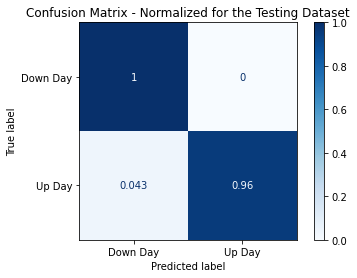

In [73]:
confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [74]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [75]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [76]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [77]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', f1_score(y_test, LogReg.predict(X_test), average='macro') * 100.0)

Correct Prediction Logistic Regression (%):  82.87526427061312


Accuracy: 88.88888888888889
Percision: 100.0
Recall: 86.95652173913044
Specificity: 100.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


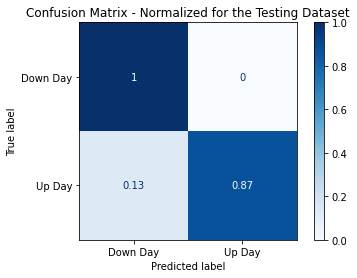

In [78]:
confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [79]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [80]:
'''
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(SVC(), param_grid, verbose = 1)              
grid.fit(X_train,y_train)
print(grid.best_params_)
'''

"\nparam_grid = {'C': [0.1, 1, 10, 100, 1000],\n              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],\n              'kernel': ['rbf','linear']}\ngrid = GridSearchCV(SVC(), param_grid, verbose = 1)              \ngrid.fit(X_train,y_train)\nprint(grid.best_params_)\n"

In [81]:
svc_classifier = SVC(kernel = 'linear',C=100,gamma=0.001, random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [82]:
# Print the Accuracy of our Model.
print('Correct Prediction SVC (%): ', f1_score(y_test, svc_classifier.predict(X_test), average='macro') * 100.0)

Correct Prediction SVC (%):  46.30681818181818


Accuracy: 48.148148148148145
Percision: 100.0
Recall: 39.130434782608695
Specificity: 100.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


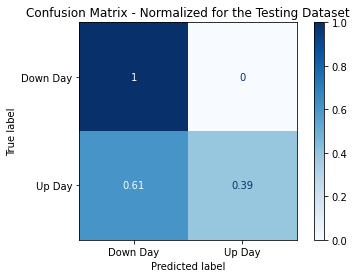

In [83]:
confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [84]:
import xgboost as xgb

In [85]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=2,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=2,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [86]:
'''
({'colsample_bytree': 0.75,
  'gamma': 0.0,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 100,
  'reg_alpha': 0.01,
  'subsample': 0.75},
 0.9968901441330651)
'''

"\n({'colsample_bytree': 0.75,\n  'gamma': 0.0,\n  'learning_rate': 0.1,\n  'max_depth': 3,\n  'min_child_weight': 1,\n  'n_estimators': 100,\n  'reg_alpha': 0.01,\n  'subsample': 0.75},\n 0.9968901441330651)\n"

In [87]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (f1_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 97.87


Accuracy: 96.29629629629629
Percision: 95.83333333333334
Recall: 100.0
Specificity: 75.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


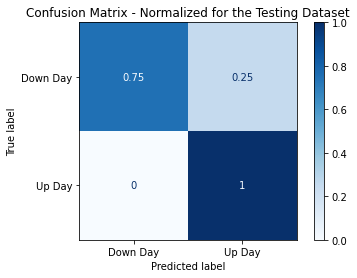

In [88]:
confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [89]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Vortex_30         38.669006
Momentum_28       30.495804
ROC_28             7.264467
RSI_30             7.070419
OBV_30             5.193521
MACDdiff_24_50     3.216093
index              2.603954
MACD_24_50         1.963202
SO%k               1.612443
MACDsign_24_50     0.886419
Volume             0.618668
sl no              0.406012
SO%d_30            0.000000
STD_30             0.000000
dtype: float32

In [90]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [91]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Vortex_30,0.235757,0.386690
Momentum_28,0.184947,0.304958
ROC_28,0.194152,0.072645
RSI_30,0.065809,0.070704
OBV_30,0.129833,0.051935
MACDdiff_24_50,0.017126,0.032161
index,0.015061,0.026040
MACD_24_50,0.062586,0.019632
SO%k,0.000502,0.016124
MACDsign_24_50,0.025549,0.008864


# Make Actual Prediction

In [ ]:
#dhftjyul8y

In [109]:
df = pd.read_csv('/content/intraday_test.csv')

In [110]:
df.columns=['sl no','Date','Open','High','Low','Close','Volume']

# Check This For Weekly or Daily

In [111]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [112]:
df = get_indicators(df,days_out,t)
#df= impulse(df)

In [113]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

In [114]:
df.shape

(106, 19)

In [115]:
df=df.dropna()

In [116]:
df.shape

(49, 19)

In [118]:
new_data = df.drop(['Open','High','Low','Close','Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [119]:
model='random_forest'

In [120]:
preds=make_preds(new_data ,rand_frst_clf,model,df)

In [121]:
print("days_out : ",days_out)

days_out :  30


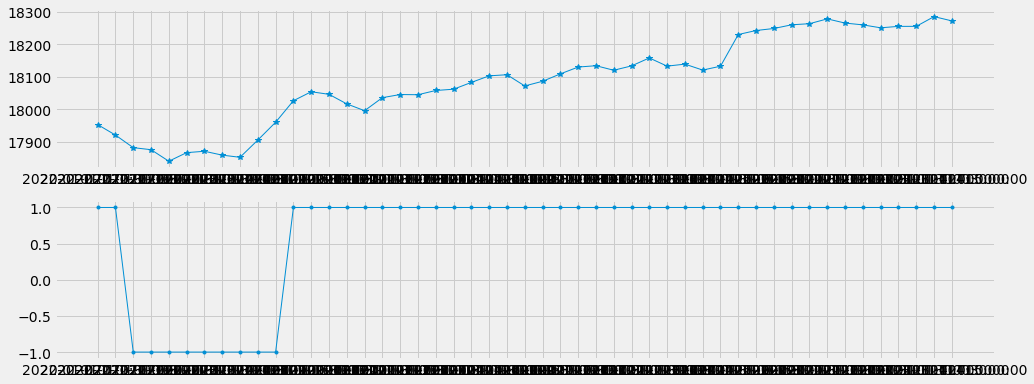

In [122]:
lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [123]:
pred = pd.DataFrame(make_preds(new_data , rand_frst_clf, model,df))

In [124]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [125]:
l= len(pred)

In [126]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [127]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [128]:
model='_XGB'

In [129]:
predX=make_preds(new_data.values ,xgb_classifier,model,df)

In [130]:
predX= pd.concat([predX ,df.Close],axis=1)

In [131]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

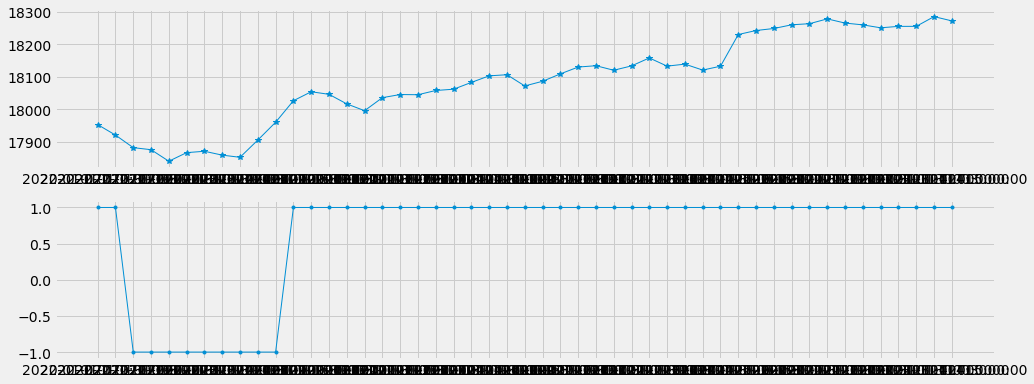

In [132]:
lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [133]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [134]:
model='_Logistic_Regression'

In [135]:
preds_logreg=pd.DataFrame(make_preds(new_data , LogReg,model, df))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [136]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2022-01-07T10:30:00,1.0
2022-01-07T11:00:00,1.0


In [137]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [138]:
predL=predL.reset_index()

In [139]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

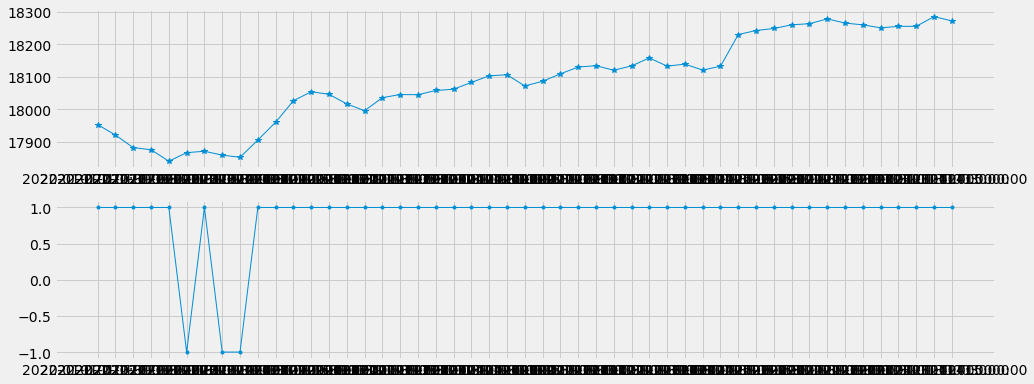

In [140]:
lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [141]:
model='_SVC'

In [142]:
preds_svc=pd.DataFrame(make_preds(new_data ,svc_classifier,model, df))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [143]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [144]:
predS=predS.reset_index()

In [145]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

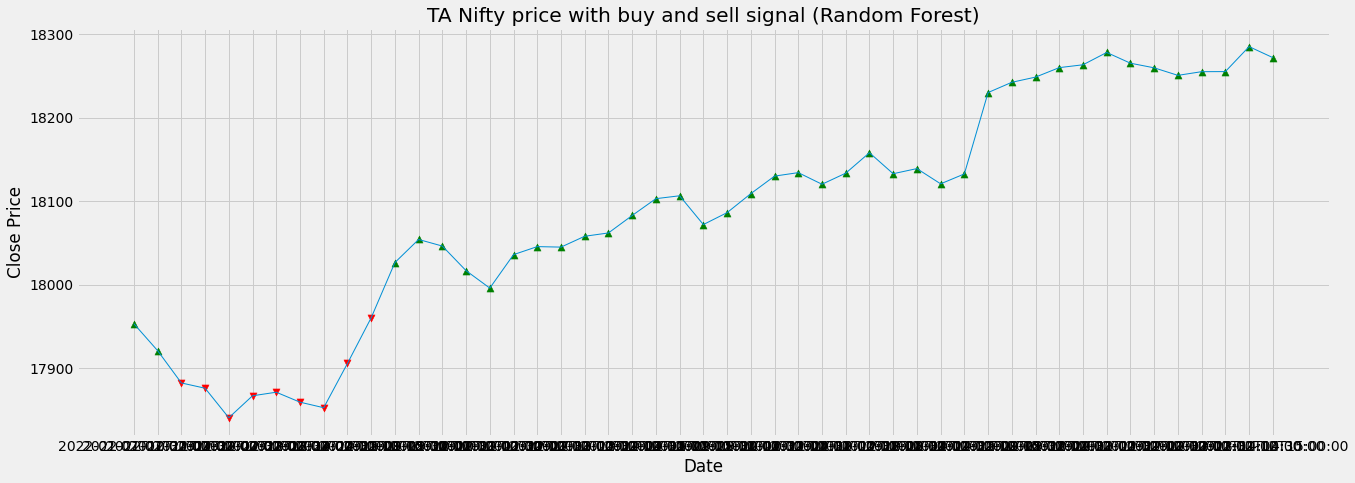

In [146]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

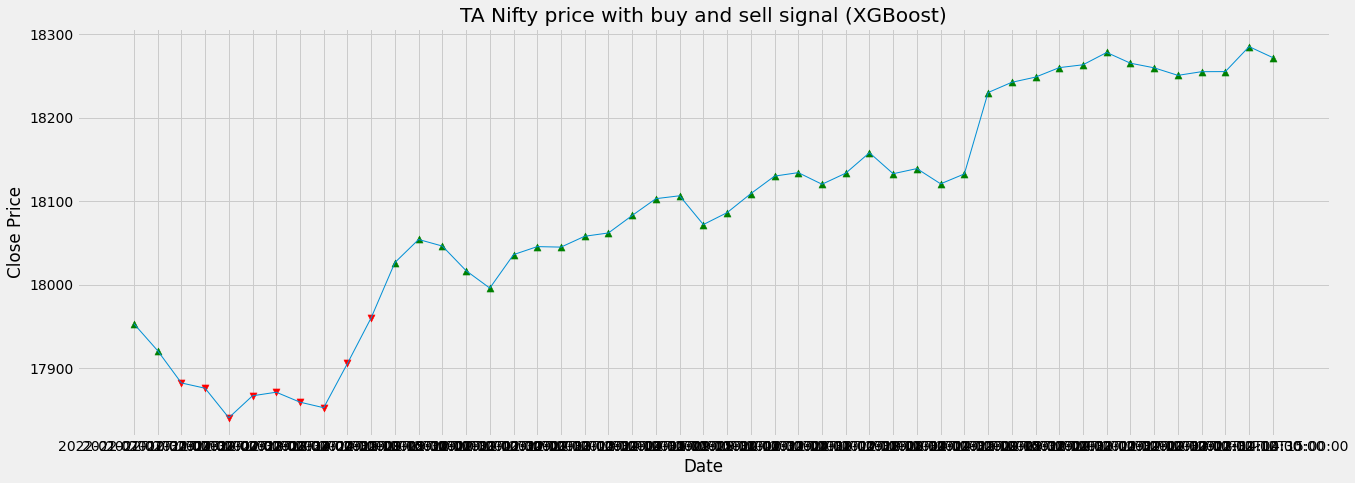

In [147]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

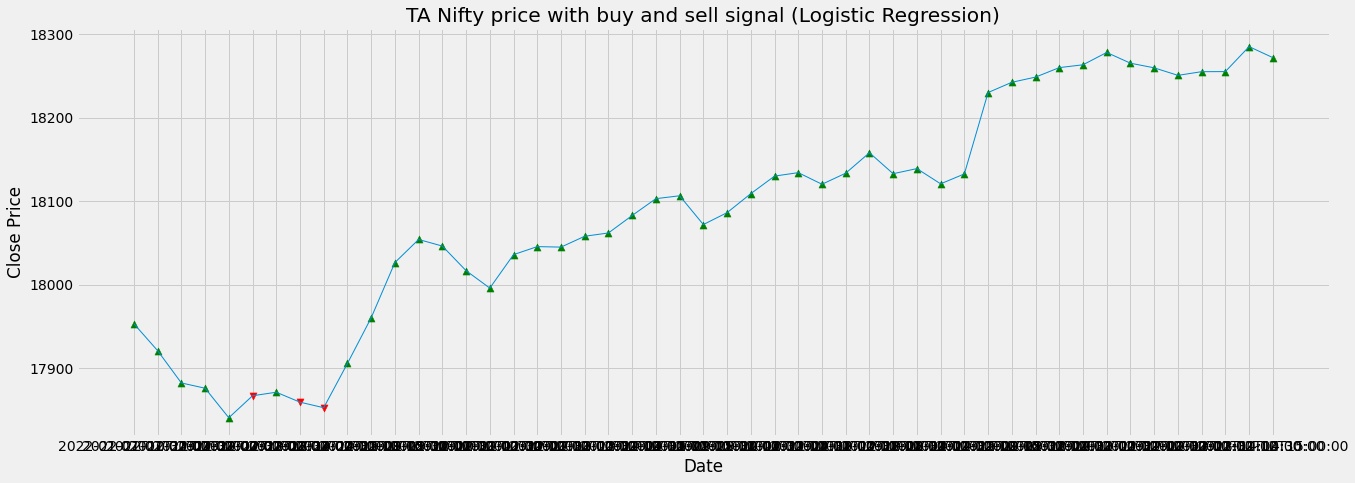

In [148]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

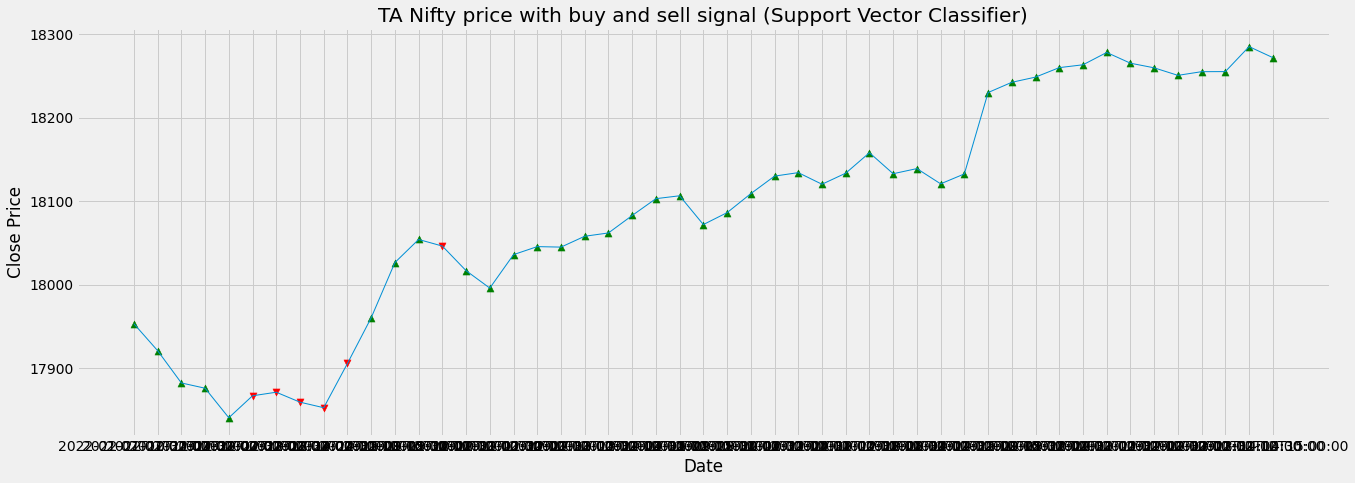

In [149]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [150]:
pred['ensemble'] = pred['predsrandom_forest']*1+predL['preds_Logistic_Regression']*0.5+predS['preds_SVC']*0.5+predX['preds_XGB']*0.5

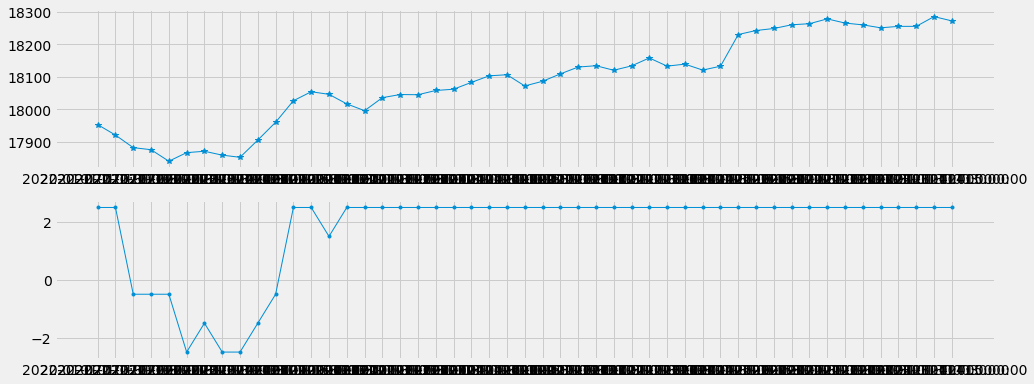

In [151]:
lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [152]:
pred['ensemble'].unique()

array([ 2.5, -0.5, -2.5, -1.5,  1.5])

In [153]:
#pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [154]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>0.5), 1, 0)
pred['Sell_ensemble'] = np.where((pred['ensemble']<0.5), -1, 0)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>0),1,0)

In [155]:
pred['signalF']=pred['signal4theday']

In [156]:
pred.to_csv('rf_ta.csv')

In [157]:
def plot_me_buy_sell_signal(pred,small_period,large_period):
  buy=[]
  sell=[]
  for i in range(len(pred)):
    if pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i]>pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i] and \
    pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i-1]<pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i-1]:
      buy.append(i)
    elif pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i]<pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i] and \
    pred.loc[:, 'Close'].ewm(span=small_period).mean().iloc[i-1]>pred.loc[:, 'Close'].ewm(span=large_period).mean().iloc[i-1]:
      sell.append(i)
  
  return buy,sell

In [158]:
buy,sell=plot_me_buy_sell_signal(pred,10,30)

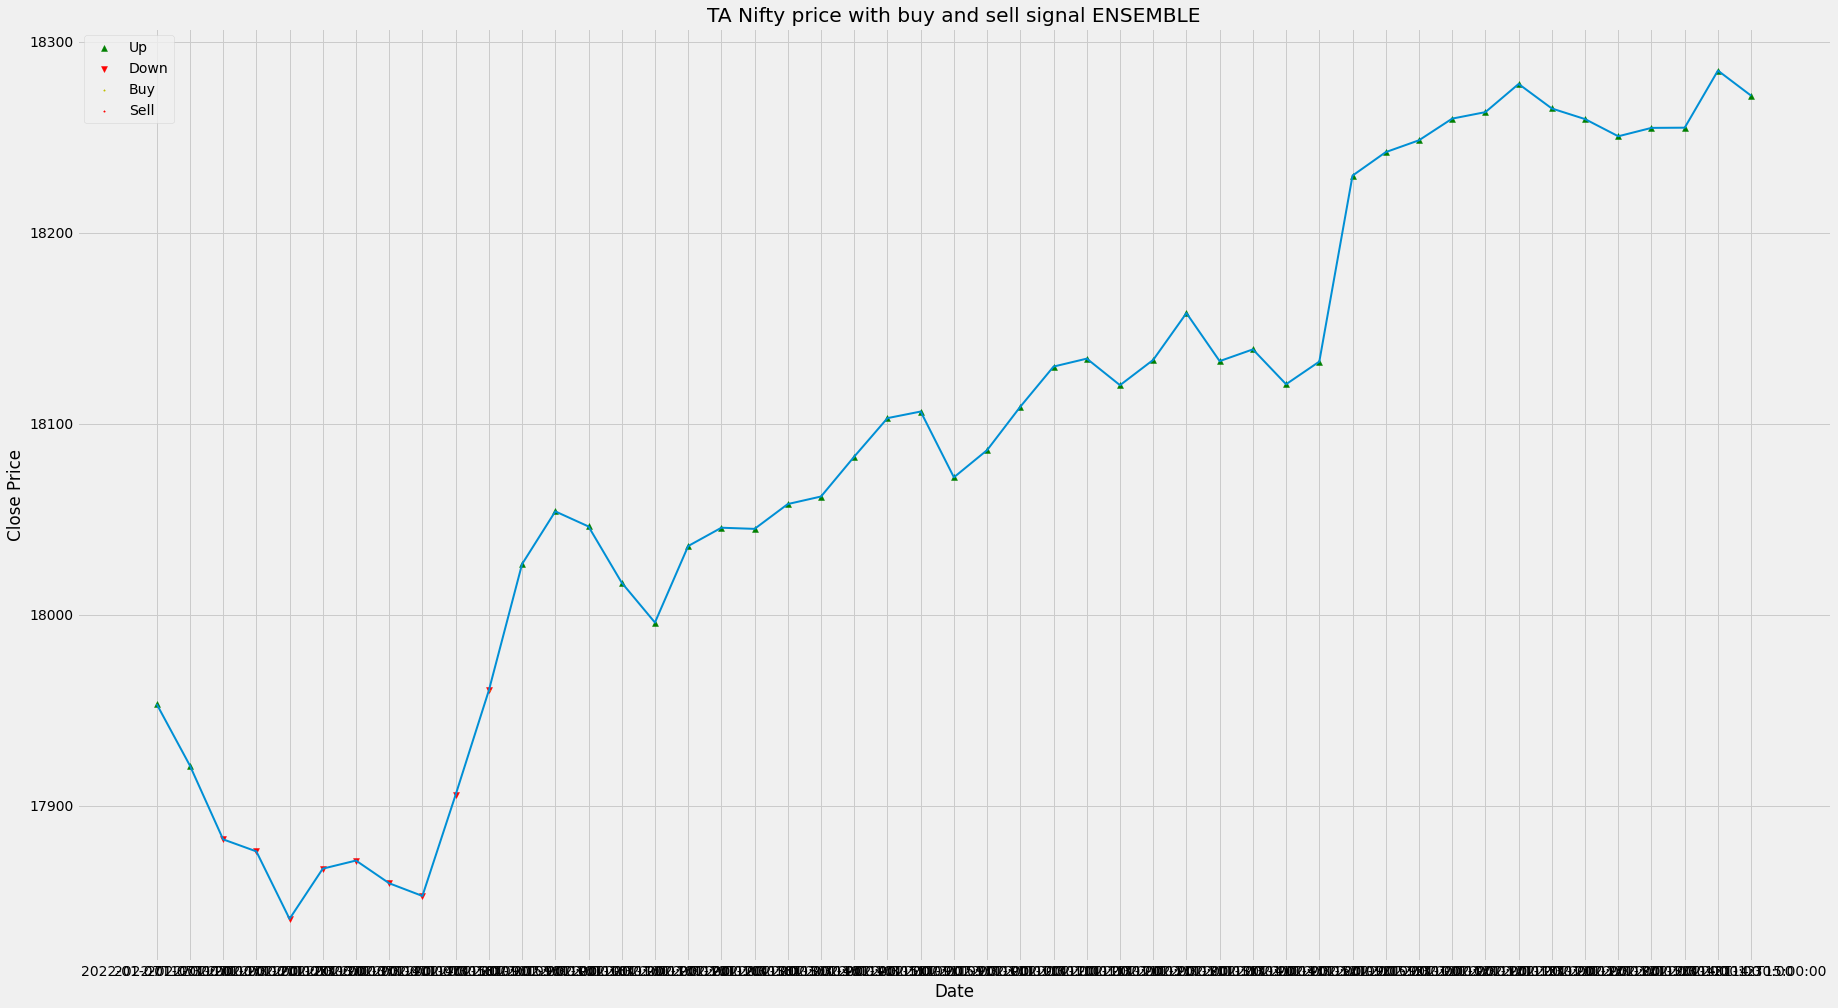

In [159]:
plt.figure(figsize=(28,16))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=35, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==-1 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==-1, 'Close'].values, label='Down', color='red', s=35, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=3,color='y',label='Buy')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='*',s=3,color='r',label='Sell')
#plt.plot(df.index,df['EMA_50'].values[-l:],label='EMA 50')
#plt.plot(df.index,df['EMA_10'].values[-l:], label='EMA 10')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

In [160]:
# saving the dataframe
pred[['Date','signalF','Close']].to_csv('/content/rf_TA.csv')

In [161]:
pred.head(1)

,Date,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
0,2022-01-07T10:30:00,1.0,17953.25,1,1,2.5,1,0,1,1


In [162]:
pred.set_index('Date',inplace=True)

In [163]:
pred.tail(2)

,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
Date,,,,,,,,,
2022-01-12T14:30:00,1.0,18285.00,1,1,2.5,1,0,1,1
2022-01-12T15:00:00,1.0,18271.85,1,1,2.5,1,0,1,1


In [164]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [165]:
pred.signalF.value_counts()

1    39
0     9
Name: signalF, dtype: int64

In [166]:
#print(f"Class 0 has {round(pred.dummyS.value_counts()[0]/(pred.dummyS.value_counts()[0]+pred.dummyS.value_counts()[1])*100)}% samples")

In [167]:
#print(f"Class 1 has {round(pred.dummyS.value_counts()[1]/(pred.dummyS.value_counts()[0]+pred.dummyS.value_counts()[1])*100)}% samples")

In [168]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score,f1_score
average_precision = average_precision_score(pred.actual, pred.dummyS)
f1=f1_score(pred.actual, pred.dummyS,average=None)
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))
print(f'f1 score class wise for down : {round(f1[0]*100)}.00% ,up : {round(f1[1]*100)}.00%')
accuracy_pos = (true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
accuracy_neg = (true_negatives) / (true_negatives + true_positives + false_negatives + false_positives)
print('Accuracy positive: {}'.format(float(accuracy_pos)))
print('Accuracy negative {}'.format(float(accuracy_neg)))

Accuracy: 0.6041666666666666
Percision: 0.6410256410256411
Recall: 0.8333333333333334
Specificity: 0.2222222222222222
F1-Score: 0.7246376811594204
Average Precision : 0.6383547008547009
f1 score class wise for down : 30.00% ,up : 72.00%
Accuracy positive: 0.5208333333333334
Accuracy negative 0.08333333333333333


In [169]:
y_true = pred.actual
y_pred = pred.dummyS
target_names = ['class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.44      0.22      0.30        18
     class 2       0.64      0.83      0.72        30

    accuracy                           0.60        48
   macro avg       0.54      0.53      0.51        48
weighted avg       0.57      0.60      0.56        48



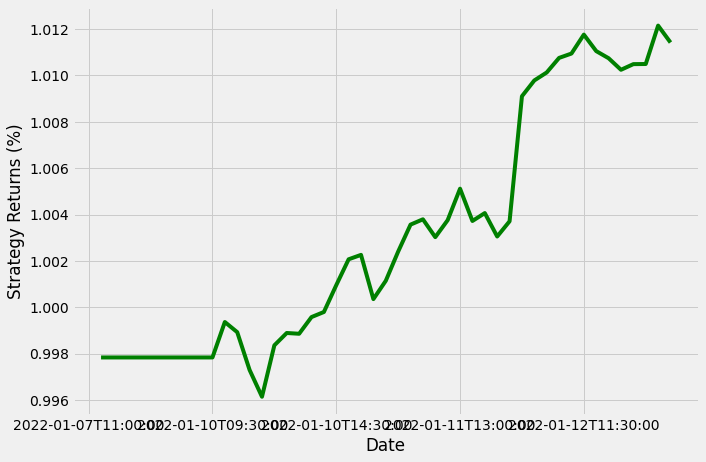

In [170]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

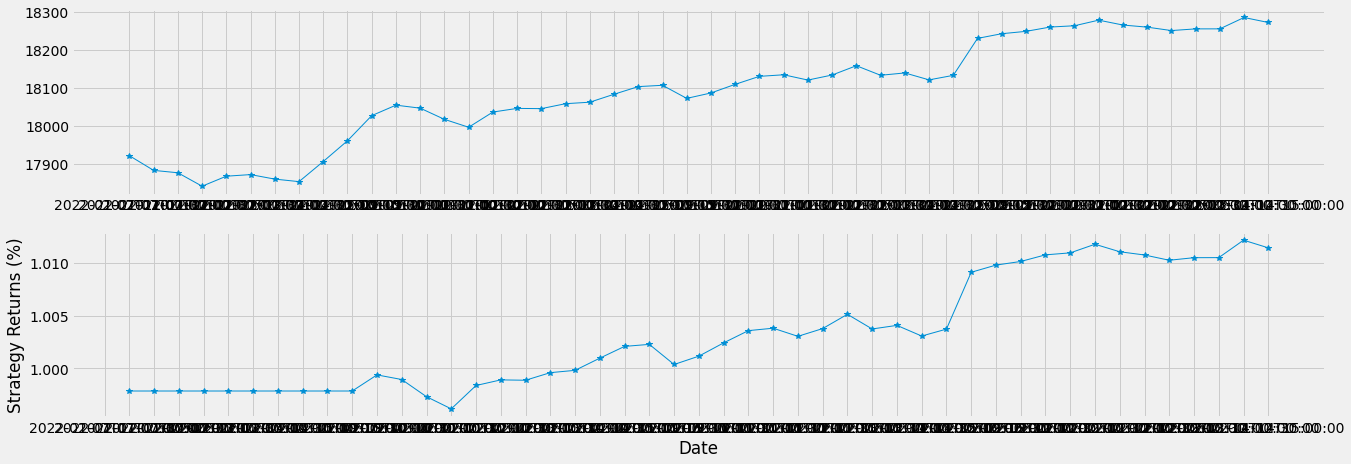

In [171]:
# Plot geometric returns
fig, ax = plt.subplots(2,1,figsize=(20,7))
ax[0].plot(pred.index,pred['Close'],'*-',linewidth=1 )
ax[1].plot(geometric_returns,'*-',linewidth=1 )
#pred.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()